In [1]:
#%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [6]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

# View the tables that were found with automap
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Explore the tables and find their column names and types

In [26]:
# Initialize the inspector
inspector = inspect(engine)

# Get column names for the Measurement Table
measurement_columns = inspector.get_columns('measurement')

# Use the inspector to print the names in the Measurement Table and its types
for column in measurement_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [27]:
# Get column names for the Measurement Table
station_columns = inspector.get_columns('station')

# Use the inspector to print the names in the Measurement Table and its types
for column in station_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

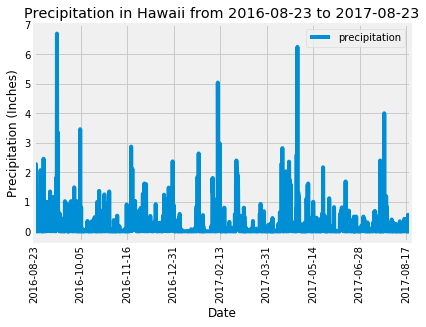

In [77]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

# First get the most current date in the data by querying date column in the Measurement table
most_current = session.query(func.max(Measurement.date)).first()

# Split the date into a list of strings in the following format: [yyyy,mm,dd]
last_date = most_current[0].split('-')

# Calculate the date 1 year ago by subtracting 365 days from the most current date
one_year = dt.date(int(last_date[0]), int(last_date[1]), int(last_date[2])) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
date_prcp_latest_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year)

# Save the query results as a Pandas DataFrame and set the index to the date column, drop NA to clean up the data
precipitation_df = pd.DataFrame(date_prcp_latest_year, columns=["date", "precipitation"]).set_index("date").dropna()

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title=f"Precipitation in Hawaii from {one_year} to {most_current[0]}", rot=90)
plt.ylabel("Precipitation (Inches)")
plt.xlabel("Date",)
plt.xlim(0,len(precipitation_df));

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [70]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.station)).first()
station_count

(9)

In [108]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [109]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Create a selection to pass into the query
min_max_avg = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

# Write out the query, unpack the selection from above, and filter for the most active station ID
most_active_station = session.query(*min_max_avg).\
    filter(Measurement.station == active_stations[0][0]).all()

to_print = np.ravel(most_active_station)

print(f"Most active station ID: {active_stations[0][0]}\n" +
      f"Lowest temperature recorded (F): {to_print[0]:.02f}\n" +
      f"Highest temperature recorded (F): {to_print[1]:.02f}\n" +
      f"Average temperature recorded (F): {to_print[2]:.02f}")

Most active station ID: USC00519281
Lowest temperature recorded (F): 54.00
Highest temperature recorded (F): 85.00
Average temperature recorded (F): 71.66


In [110]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

## Bonus Challenge Assignment

In [15]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [16]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [17]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [18]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [19]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [20]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [21]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [22]:
# Plot the daily normals as an area plot with `stacked=False`
